In [1]:
%load_ext lab_black

# NOTEBOOK FOR SPECTRA RESAMPLING AND COMBINATION TESTING
Ideally want to resample the wavelength grid to that of our spectral resolution
- We can oversample but this will lead to correlation between points

# Import Packages

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apnndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import scipy as sp
import scipy.optimize as spopt
import copy
import grismconf
import sys
import spectres

# Load in Functions from Original Script

In [3]:
%run Functions_Notebook.ipynb

/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-040-001 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-051
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# Load in Datasets required

## Load Image File

In [4]:
file_name = "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/F444W_grism/F444W_Level15_Frames/jw01309025001_01101_00002_nrca5_rate_lv1.5.fits"
fits_file = apfits.open(file_name)
# print(repr(fits_file["SCI"].header))
file_data = fits_file["SCI"].data

## Data Loading Function

In [5]:
def load_data(row):
    if row.Fnames.endswith(".npy"):
        return np.load(row.Fnames, allow_pickle=True)
    elif row.Fnames.endswith(".pkl"):
        return pd.read_pickle(row.Fnames)
    elif row.Fnames.endswith(".fits"):
        return apfits.open(row.Fnames)
    elif row.Fnames.endswith(".txt"):
        return pd.read_csv(row.Fnames, delim_whitespace=True, skiprows=[1], header=[0])
    else:
        return row.Fnames

## Melissa's Target list - WON'T DO THIS STEP WITH REAL DATA AS RA AND DEC MATCHING NOT POSS


In [6]:
# Imported the data assocaited with each source within the field of view sorted by its catalogue ID
melissa_input_spectra = pd.read_csv(
    "reddened_stars_march22/BGstars_final_catalog.txt", delim_whitespace=True
).sort_values(by=["No."])

In [7]:
fnames = list(glob.glob("reddened_stars_march22/redspect*.txt"))

catalogue_number = np.array(
    [os.path.basename(fname).split("_")[1].split(".")[0] for fname in fnames]
)
# Re-orders file to match FNames Dataframe
catalogue_number.sort()

sourceinputspecdf = pd.DataFrame(fnames, columns=(["Fnames"])).sort_values(by="Fnames")
sourceinputspecdf["CatalogueNumber"] = catalogue_number

# Turn all catalogue Numbers integers for dataframe source matching
sourceinputspecdf["CatalogueNumber"] = [
    int(sourceinputspecdf["CatalogueNumber"].iloc[i])
    for i in range(len(sourceinputspecdf["CatalogueNumber"]))
]

# Sort by Catalogue Number as integer to match sources with final_catalog file
sourceinputspecdf = sourceinputspecdf.sort_values(by="CatalogueNumber")

In [8]:
# Takes a minute
InputSpectraData = sourceinputspecdf.apply(load_data, axis=1)

In [9]:
sourceinputspecdf["SourceInputWavelengths"] = [
    np.array(InputSpectraData[i]["wavelength"])
    for i in range(InputSpectraData.shape[0])
]

sourceinputspecdf["SourceInputFluxes"] = [
    np.array(InputSpectraData[i]["flux"]) for i in range(InputSpectraData.shape[0])
]

### Add into Input Source catalogue information dataframe 

Could do this in the step above but WORTH A CHECK THAT THE DATAFRAMES ARE IN SAME ORDER

In [10]:
melissa_input_spectra["SourceInputWavelengths"] = sourceinputspecdf[
    "SourceInputWavelengths"
]
melissa_input_spectra["SourceInputFluxes"] = sourceinputspecdf["SourceInputFluxes"]

### RA and Dec sorted / indexed for combination with all other data

In [11]:
melissa_input_spectra = melissa_input_spectra.sort_values(["RA", "Dec"]).set_index(
    ["RA", "Dec"]
)

## Organise every single dataset by associated Filter, Direction, Module, Primary Dither (and eventually Sub-Pixel)

In [12]:
COfnames = list(glob.glob("F444W_Test_Frame_Cluster_Outputs/*.*"))

COdf = pd.DataFrame.from_records(
    np.array([os.path.basename(fname).split("_")[:11] for fname in COfnames])
)

file_types = np.array(
    [
        "_".join(os.path.basename(fname).split("_")[11:]).split(".")[0]
        for fname in COfnames
    ]
)

COdf["Fnames"] = COfnames
COdf["Ftypes"] = file_types

COdf.set_index([6, 8, 7, 9, "Ftypes"], inplace=True)

COdf.index.rename(
    {6: "Filter", 8: "Direction", 7: "Module", 9: "PrimaryExp"}, inplace=True
)

COdf.drop(columns=[0, 1, 2, 3, 4, 5, 10], inplace=True)

COdf.sort_values(by="Fnames", inplace=True)

# df
# df.loc[("F444W", "R")]

In [13]:
# np.array([os.path.basename(fname).split("_")[:11] for fname in H2Ofnames])

In [14]:
H2Ofnames = list(glob.glob("F322W2_Cluster_outputs/*.*"))

In [15]:
np.array([os.path.basename(fname).split("_")[:11] for fname in H2Ofnames])

array([['jw01309023001', '01101', '00007', ..., 'R', 'Primary2',
        'Exp00007'],
       ['jw01309023001', '01101', '00009', ..., 'R', 'Primary3',
        'Exp00009'],
       ['jw01309024001', '01101', '00004', ..., 'C', 'Primary1',
        'Exp00004'],
       ...,
       ['jw01309024002', '01101', '00025', ..., 'C', 'Primary3',
        'Exp00025'],
       ['jw01309024001', '01101', '00001', ..., 'C', 'Primary1',
        'Exp00001'],
       ['jw01309024002', '01101', '00019', ..., 'C', 'Primary1',
        'Exp00019']], dtype='<U13')

In [16]:
H2Odf = pd.DataFrame.from_records(
    np.array([os.path.basename(fname).split("_")[:11] for fname in H2Ofnames])
)


file_types = np.array(
    [
        "_".join(os.path.basename(fname).split("_")[11:]).split(".")[0]
        for fname in H2Ofnames
    ]
)

H2Odf["Fnames"] = H2Ofnames
H2Odf["Ftypes"] = file_types

H2Odf.set_index([6, 8, 7, 9, "Ftypes"], inplace=True)

H2Odf.index.rename(
    {6: "Filter", 8: "Direction", 7: "Module", 9: "PrimaryExp"}, inplace=True
)

H2Odf.drop(columns=[0, 1, 2, 3, 4, 5, 10], inplace=True)

H2Odf.sort_values(by="Fnames", inplace=True)

# df
# df.loc[("F444W", "R")]

## Load in all the data associated with the Organised files 

In [17]:
COdata = COdf.apply(load_data, axis=1)
# data

H2Odata = H2Odf.apply(load_data, axis=1)

# data.swaplevel(1) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.swaplevel.html

## Combine all the trace information for each source from every source

In [18]:
COsourceinfo = pd.concat(
    [
        COdata.swaplevel(0).loc["fitted_dataframe"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["fitted_dataframe"].values))
    ],
)

H2Osourceinfo = pd.concat(
    [
        H2Odata.swaplevel(0).loc["fitted_dataframe"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["fitted_dataframe"].values))
    ]
)

In [19]:
H2Osourceinfo

,low_WL_trace_end_pixel,high_WL_trace_end_pixel,Direct_X_pixel,Direct_Y_pixel,RA,Dec,Order,FengwuID
0,822,3254,3.032,1837.106,166.52321,-77.411697,2,17
1,850,3282,31.840,647.845,166.49239,-77.392059,2,45
2,853,3285,34.662,1146.525,166.50655,-77.400230,2,98
3,871,3303,52.760,94.662,166.47824,-77.382774,2,322
4,883,3315,64.507,1502.516,166.51862,-77.405869,2,266
...,...,...,...,...,...,...,...,...
479,1533,3277,416.084,3074.754,166.75619,-77.366257,1,191
480,1537,3281,208.675,3078.393,166.75187,-77.369717,1,377
481,1538,3282,1413.769,3079.070,166.77937,-77.349861,1,37
482,1538,3282,394.161,3079.808,166.75609,-77.366646,1,67


## ADD IN DETAILS OF WHICH FRAME THE SOURCE IS FROM

In [19]:
COfilter_arr = np.concatenate(
    [
        [COdata.swaplevel(0).loc["fitted_dataframe"].index[i][3]]
        * len(COdata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(COdata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
COsourceinfo["Filter"] = COfilter_arr

COprimary_exp_arr = np.concatenate(
    [
        [COdata.swaplevel(0).loc["fitted_dataframe"].index[i][2]]
        * len(COdata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(COdata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
COsourceinfo["PrimaryExp"] = COprimary_exp_arr

COmodule_arr = np.concatenate(
    [
        [COdata.swaplevel(0).loc["fitted_dataframe"].index[i][1]]
        * len(COdata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(COdata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
COsourceinfo["Module"] = COmodule_arr

COdirection_arr = np.concatenate(
    [
        [COdata.swaplevel(0).loc["fitted_dataframe"].index[i][0]]
        * len(COdata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(COdata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
COsourceinfo["Direction"] = COdirection_arr

H2Ofilter_arr = np.concatenate(
    [
        [H2Odata.swaplevel(0).loc["fitted_dataframe"].index[i][3]]
        * len(H2Odata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(H2Odata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
H2Osourceinfo["Filter"] = H2Ofilter_arr

H2Oprimary_exp_arr = np.concatenate(
    [
        [H2Odata.swaplevel(0).loc["fitted_dataframe"].index[i][2]]
        * len(H2Odata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(H2Odata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
H2Osourceinfo["PrimaryExp"] = H2Oprimary_exp_arr

H2Omodule_arr = np.concatenate(
    [
        [H2Odata.swaplevel(0).loc["fitted_dataframe"].index[i][1]]
        * len(H2Odata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(H2Odata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
H2Osourceinfo["Module"] = H2Omodule_arr

H2Odirection_arr = np.concatenate(
    [
        [H2Odata.swaplevel(0).loc["fitted_dataframe"].index[i][0]]
        * len(H2Odata.swaplevel(0).loc["fitted_dataframe"].values[i])
        for i in range(len(H2Odata.swaplevel(0).loc["fitted_dataframe"].index))
    ]
)
H2Osourceinfo["Direction"] = H2Odirection_arr

### Set index to Exposure details

!!! WITH DATA, ADD A SUB-PIXEL DITHER INDEX TO DATA TOO !!!

!!! WITH DATA, ADD A SUB-PIXEL DITHER INDEX TO DATA TOO !!!

!!! WITH DATA, ADD A SUB-PIXEL DITHER INDEX TO DATA TOO !!!

## Load in Sensitivity Curves

In [20]:
H2OSensFnames = list(
    glob.glob(
        "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCam.F322W2*"
    )
)

# Only load in the 1st order sensitivity curves as only first order traces are strong enough in this filter
COSensFnames = list(
    glob.glob(
        "/Users/zx446701/OneDrive - The Open University/Ice_Age/Fengwu_Sims_2/GRISM_NIRCAM-master/V3/NIRCam.F444W*1st*"
    )
)

# COSensFnames

### Create Sensitivity Curve information Dataframes

In [21]:
# THERE ARE NO FILES WITH DIRECTION = C
COSensdf = pd.DataFrame.from_records(
    np.array([os.path.basename(fname).split(".")[1:5] for fname in COSensFnames])
)
COSensdf[3] = [
    int(COSensdf[3][i][0]) for i in range(len(COSensdf[3]))
]  # Make '1st' string an integer 1

COSensdf["Fnames"] = COSensFnames
COSensdf.set_index([0, 1, 2, 3], inplace=True)
COSensdf.index.rename(
    {0: "Filter", 1: "Direction", 2: "Module", 3: "Order"}, inplace=True
)

COSensData = COSensdf.apply(load_data, axis=1,)

In [22]:
H2OSensdf = pd.DataFrame.from_records(
    np.array([os.path.basename(fname).split(".")[1:5] for fname in H2OSensFnames])
)
H2OSensdf[3] = [
    int(H2OSensdf[3][i][0]) for i in range(len(H2OSensdf[3]))
]  # Make '1st' string an integer 1

H2OSensdf["Fnames"] = H2OSensFnames
H2OSensdf.set_index([0, 1, 2, 3], inplace=True)
H2OSensdf.index.rename(
    {0: "Filter", 1: "Direction", 2: "Module", 3: "Order"}, inplace=True
)

H2OSensData = H2OSensdf.apply(load_data, axis=1,)

### Extract the data and interpolate them

In [23]:
COSensTable = [aptable.Table(COSensData[i][1].data) for i in range(len(COSensData))]
COSensDataWL = [COSensTable[i][0][:] for i in range(len(COSensTable))]
COSensDataSens = [COSensTable[i][1][:] for i in range(len(COSensTable))]
COSensDataEr = [COSensTable[i][2][:] for i in range(len(COSensTable))]

COSensCurve = [
    sp.interpolate.interp1d(
        COSensDataWL[i], COSensDataSens[i], kind="cubic", fill_value="extrapolate"
    )
    for i in range(len(COSensDataWL))
]

H2OSensTable = [aptable.Table(H2OSensData[i][1].data) for i in range(len(H2OSensData))]
H2OSensDataWL = [H2OSensTable[i][0][:] for i in range(len(H2OSensTable))]
H2OSensDataSens = [H2OSensTable[i][1][:] for i in range(len(H2OSensTable))]
H2OSensDataEr = [H2OSensTable[i][2][:] for i in range(len(H2OSensTable))]

H2OSensCurve = [
    sp.interpolate.interp1d(
        H2OSensDataWL[i], H2OSensDataSens[i], kind="cubic", fill_value="extrapolate"
    )
    for i in range(len(H2OSensDataWL))
]

In [24]:
COSensdf["SensitivityCurve"] = COSensCurve
COSensdf.drop(columns="Fnames", inplace=True)

H2OSensdf["SensitivityCurve"] = H2OSensCurve
H2OSensdf.drop(columns="Fnames", inplace=True)

In [25]:
COsourceinfo

,low_WL_trace_end_pixel,high_WL_trace_end_pixel,Direct_X_pixel,Direct_Y_pixel,RA,Dec,Order,FengwuID,Filter,PrimaryExp,Module,Direction
0,-533,832,-366.646,806.506,166.25000,-77.412651,1,54,F444W,Primary1,A,R
1,-517,848,-350.109,260.409,166.23558,-77.403549,1,343,F444W,Primary1,A,R
2,-500,865,-333.228,866.027,166.25421,-77.413422,1,154,F444W,Primary1,A,R
3,-469,896,-302.570,1658.630,166.27869,-77.426186,1,347,F444W,Primary1,A,R
4,-459,906,-292.417,1416.784,166.27274,-77.422180,1,345,F444W,Primary1,A,R
...,...,...,...,...,...,...,...,...,...,...,...,...
156,1867,3213,445.554,2024.645,166.53682,-77.424301,1,318,F444W,Primary3,B,C
157,1871,3217,1497.637,2028.501,166.61916,-77.421150,1,250,F444W,Primary3,B,C
158,1871,3217,1915.084,2028.925,166.65184,-77.419945,1,310,F444W,Primary3,B,C
159,1879,3225,1174.518,2036.867,166.59402,-77.422256,1,171,F444W,Primary3,B,C


In [26]:
COsourceinfo.set_index(
    ["Filter", "Direction", "Module", "PrimaryExp", "Order"], inplace=True
)

H2Osourceinfo.set_index(
    ["Filter", "Direction", "Module", "PrimaryExp", "Order"], inplace=True
)

In [27]:
COsourceinfo["InterpSensitivityCurve"] = None
temp = COsourceinfo.swaplevel(1, 2)
temp.loc[("F444W", "A"), "InterpSensitivityCurve"] = (
    COSensdf.swaplevel(1, 2).loc[("F444W", "A"), "SensitivityCurve"].values[0]
)
temp.loc[("F444W", "B"), "InterpSensitivityCurve"] = (
    COSensdf.swaplevel(1, 2).loc[("F444W", "B"), "SensitivityCurve"].values[0]
)
COsourceinfo = temp.swaplevel(1, 2)

/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/zx446701/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/core/async_helpers.py:78: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [28]:
H2Osourceinfo["InterpSensitivityCurve"] = None
temp = H2Osourceinfo.swaplevel(1, 2).swaplevel(2)
temp.loc[("F322W2", "A", 1), "InterpSensitivityCurve"] = (
    H2OSensdf.swaplevel(1, 2)
    .swaplevel(2)
    .loc[("F322W2", "A", 1), "SensitivityCurve"]
    .values[0]
)
temp.loc[("F322W2", "B", 1), "InterpSensitivityCurve"] = (
    H2OSensdf.swaplevel(1, 2)
    .swaplevel(2)
    .loc[("F322W2", "B", 1), "SensitivityCurve"]
    .values[0]
)
temp.loc[("F322W2", "A", 2), "InterpSensitivityCurve"] = (
    H2OSensdf.swaplevel(1, 2)
    .swaplevel(2)
    .loc[("F322W2", "A", 2), "SensitivityCurve"]
    .values[0]
)
temp.loc[("F322W2", "B", 2), "InterpSensitivityCurve"] = (
    H2OSensdf.swaplevel(1, 2)
    .swaplevel(2)
    .loc[("F322W2", "B", 2), "SensitivityCurve"]
    .values[0]
)

H2Osourceinfo = temp.swaplevel(1, 2).swaplevel(1)

## Add additional data to the complete dataframe

In [29]:
COsourceinfo["TraceWL"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["trace_WL"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["trace_WL"]))
    ]
).tolist()

COsourceinfo["TraceX"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["trace_x_pixels"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["trace_x_pixels"]))
    ]
).tolist()

COsourceinfo["TraceY"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["trace_y_pixels"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["trace_y_pixels"]))
    ]
).tolist()


# Import Opt Box Result Fluxes
COsourceinfo["OptBoxResult"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["OptBox_results_array"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["OptBox_results_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
COsourceinfo["OptBoxResult"] = [
    np.array(COsourceinfo["OptBoxResult"].values[i])
    for i in range(len(COsourceinfo["OptBoxResult"].values))
]

# Import PSF Standard IP Result Fluxes
COsourceinfo["StandardIPResult"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["result_array"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["result_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
COsourceinfo["StandardIPResult"] = [
    np.array(COsourceinfo["StandardIPResult"].values[i])
    for i in range(len(COsourceinfo["StandardIPResult"].values))
]


# Import PSF Standard IP Errors
COsourceinfo["StandardIPResultErr"] = np.concatenate(
    [
        COdata.swaplevel(0).loc["result_error_array"].values[i]
        for i in range(len(COdata.swaplevel(0).loc["result_error_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
COsourceinfo["StandardIPResultErr"] = [
    np.array(COsourceinfo["StandardIPResultErr"].values[i])
    for i in range(len(COsourceinfo["StandardIPResultErr"].values))
]

In [37]:
len(
    np.concatenate(
        [
            COdata.swaplevel(0).loc["result_error_array"].values[i]
            for i in range(len(COdata.swaplevel(0).loc["result_error_array"]))
        ]
    ).tolist()
)

17052

In [21]:
COdata

Filter  Direction  Module  PrimaryExp  Ftypes              
F444W   R          A       Primary1    OptBox_results_array    [[nan, nan, nan, nan, -0.04654287491651966, -0...
                                       fitted_dataframe             low_WL_trace_end_pixel  high_WL_trace_end...
                                       result_array            [[0.0, 0.0, 0.0, 0.0, -0.029606108827186346, -...
                                       result_error_array      [[1.0, 1.0, 1.0, 1.0, 0.8325144294468733, 0.89...
                                       trace_WL                [[4.305469244153728, 4.306473247544873, 4.3074...
                                                                                     ...                        
        C          B       Primary3    result_array            [[0.0, 0.0, 0.0, 0.0, -0.128430631998526, -0.0...
                                       result_error_array      [[1.0, 1.0, 1.0, 1.0, 0.9289100003296583, 0.97...
                                    

In [20]:
H2Odata

Filter  Direction  Module  PrimaryExp  Ftypes            
F322W2  R          A       Primary1    fitted_dataframe           low_WL_trace_end_pixel  high_WL_trace_end...
                                       result_array          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                       result_error_array    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                       trace_WL              [[2.3796393885414586, 2.3801413902372484, 2.38...
                                       trace_x_pixels        [[822, 823, 824, 825, 826, 827, 828, 829, 830,...
                                                                                   ...                        
        C          B       Primary3    result_array          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                       result_error_array    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                       trace_WL       

In [32]:
len(
    np.concatenate(
        [
            H2Odata.swaplevel(0).loc["trace_WL"].values[i]
            for i in range(len(H2Odata.swaplevel(0).loc["trace_WL"]))
        ]
    ).tolist()
)

37078

In [34]:
H2Osourceinfo

low_WL_trace_end_pixel  \
Filter Direction Module PrimaryExp Order                           
F322W2 R         A      Primary1   2                         822   
                                   2                         850   
                                   2                         853   
                                   2                         871   
                                   2                         883   
...                                                          ...   
       C         B      Primary3   1                        1533   
                                   1                        1537   
                                   1                        1538   
                                   1                        1538   
                                   1                        1566   

                                          high_WL_trace_end_pixel  \
Filter Direction Module PrimaryExp Order                            
F322W2 R         A      Primary1   2                         3254   
                                   2                         3282   
                                   2                         3285   
                                   2                         3303   
                                   2                         3315   
...                                                           ...   
       C         B      Primary3   1                         3277   
                                   1                         3281   
                                   1                         3282   
                                   1                         3282   
                                   1                         3310   

                                          Direct_X_pixel  Direct_Y_pixel  \
Filter Direction Module PrimaryExp Order                                   
F322W2 R         A      Primary1   2               3.032        1837.106   
                                   2              31.840         647.845   
                                   2              34.662        1146.525   
                                   2              52.760          94.662   
                                   2              64.507        1502.516   
...                                                  ...             ...   
       C         B      Primary3   1             416.084        3074.754   
                                   1             208.675        3078.393   
                                   1            1413.769        3079.070   
                                   1             394.161        3079.808   
                                   1             331.756        3107.455   

                                                 RA        Dec  FengwuID  \
Filter Direction Module PrimaryExp Order                                   
F322W2 R         A      Primary1   2      166.52321 -77.411697        17   
                                   2      166.49239 -77.392059        45   
                                   2      166.50655 -77.400230        98   
                                   2      166.47824 -77.382774       322   
                                   2      166.51862 -77.405869       266   
...                                             ...        ...       ...   
       C         B      Primary3   1      166.75619 -77.366257       191   
                                   1      166.75187 -77.369717       377   
                                   1      166.77937 -77.349861        37   
                                   1      166.75609 -77.366646        67   
                                   1      166.75683 -77.367822       390   

                                                                     InterpSensitivityCurve  
Filter Direction Module PrimaryExp Order                                                     
F322W2 R         A      Primary1   2      <scipy.interpolate.interpolate.interp1d object...  

In [29]:
H2Osourceinfo["TraceWL"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["trace_WL"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["trace_WL"]))
    ]
).tolist()

H2Osourceinfo["TraceX"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["trace_x_pixels"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["trace_x_pixels"]))
    ]
).tolist()

H2Osourceinfo["TraceY"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["trace_y_pixels"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["trace_y_pixels"]))
    ]
).tolist()


# Import Opt Box Result Fluxes
H2Osourceinfo["OptBoxResult"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["OptBox_results_array"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["OptBox_results_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
H2Osourceinfo["OptBoxResult"] = [
    np.array(H2Osourceinfo["OptBoxResult"].values[i])
    for i in range(len(H2Osourceinfo["OptBoxResult"].values))
]

# Import PSF Standard IP Result Fluxes
H2Osourceinfo["StandardIPResult"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["result_array"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["result_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
H2Osourceinfo["StandardIPResult"] = [
    np.array(H2Osourceinfo["StandardIPResult"].values[i])
    for i in range(len(H2Osourceinfo["StandardIPResult"].values))
]


# Import PSF Standard IP Errors
H2Osourceinfo["StandardIPResultErr"] = np.concatenate(
    [
        H2Odata.swaplevel(0).loc["result_error_array"].values[i]
        for i in range(len(H2Odata.swaplevel(0).loc["result_error_array"]))
    ]
).tolist()

# Convert values from lists to ARRAY for easier operation working
H2Osourceinfo["StandardIPResultErr"] = [
    np.array(H2Osourceinfo["StandardIPResultErr"].values[i])
    for i in range(len(H2Osourceinfo["StandardIPResultErr"].values))
]

ValueError: Length of values (37078) does not match length of index (32494)

In [131]:
"""EXAMPLE OF WHY ARRAY IS NEEDED FOR CONDITIONS - AS A LIST THIS DOES NOT WORK"""
# sourceinfo["StandardIPResult"].iloc[0][sourceinfo["StandardIPResult"].iloc[0] != 0]

'EXAMPLE OF WHY ARRAY IS NEEDED FOR CONDITIONS - AS A LIST THIS DOES NOT WORK'

# Sensitivity Curve Setup & Crossover (for filter combination) - TAKING INTERPOLATION SENS CURVE AND TURNING INTO REAL SENSITIVITY CURVE

Only necessary for 1st Order traces as F444W 2nd order traces are not strong enough, also the wavelengths will not crossover even if it was 

## Have to nan-pad the wavelengths for the sensitivity curve to ensure results can be divided by sens curve

In [132]:
nan_padded_TraceWLs = []
for i in range(len(sourceinfo)):
    nan_padded_TraceWL = np.full_like(sourceinfo["StandardIPResult"].iloc[i], np.nan)
    if sourceinfo.index.get_level_values(1)[i] == "R":
        for i, (x, w) in enumerate(
            zip(sourceinfo["TraceX"].iloc[i], sourceinfo["TraceWL"].iloc[i])
        ):
            try:
                nan_padded_TraceWL[x] = w
            except ValueError as e:
                print(i, e)

    else:
        for i, (y, w) in enumerate(
            zip(sourceinfo["TraceY"].iloc[i], sourceinfo["TraceWL"].iloc[i])
        ):
            try:
                nan_padded_TraceWL[y] = w
            except ValueError as e:
                print(i, e)

    nan_padded_TraceWLs.append(nan_padded_TraceWL)

sourceinfo["NaNPaddedTraceWL"] = nan_padded_TraceWLs

In [133]:
# NEED TO NAN PAD THE WAVELENGTHS SO THAT THE FIT RESULTS ARE ABLE TO BE DIVIDED BY THE SENSITIVITY CURVE
sourceinfo["SensitivityCurve"] = [
    sourceinfo["InterpSensitivityCurve"].values[i](
        sourceinfo["NaNPaddedTraceWL"].iloc[i]
    )
    for i in range(len(sourceinfo["NaNPaddedTraceWL"]))
]

## Flux Calibrated Results and Errors

In [134]:
# Flux Calibrating PSF Standard IP fit
sourceinfo["CalibratedStandardIPResult"] = [
    sourceinfo["StandardIPResult"].iloc[i] / sourceinfo["SensitivityCurve"].iloc[i]
    for i in range(len(sourceinfo))
]

# Flux Calibrating PSF Standard IP fit errors
sourceinfo["CalibratedStandardIPResultErr"] = [
    sourceinfo["StandardIPResultErr"].iloc[i] / sourceinfo["SensitivityCurve"].iloc[i]
    for i in range(len(sourceinfo))
]

# Flux Calibrating Optimal Box Method
sourceinfo["CalibratedOptBoxResult"] = [
    sourceinfo["OptBoxResult"].iloc[i] / sourceinfo["SensitivityCurve"].iloc[i]
    for i in range(len(sourceinfo))
]

(-1e-17, 1e-17)

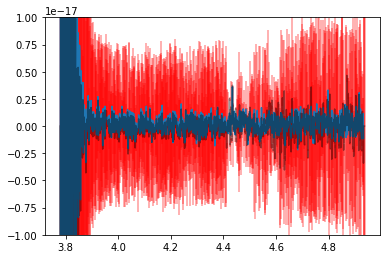

In [135]:
mplplot.errorbar(
    sourceinfo["NaNPaddedTraceWL"].iloc[1000],
    sourceinfo["CalibratedStandardIPResult"].iloc[1000],
    yerr=sourceinfo["CalibratedStandardIPResultErr"].iloc[1000],
    color="k",
    ecolor="r",
    alpha=0.4,
)
# mplplot.plot(
#     sourceinfo["NaNPaddedTraceWL"].iloc[1000],
#     sourceinfo["CalibratedOptBoxResult"].iloc[1000],
# )
mplplot.ylim(-1e-17, 1e-17)

## Convert flux units to mJy 

In [136]:
# Takes a minute
sourceinfo["mJyCalibratedStandardIPResult"] = [
    (
        sourceinfo["CalibratedStandardIPResult"].iloc[i]
        * apunits.erg
        / apunits.s
        / apunits.angstrom
        / apunits.cm ** 2
    ).to(
        apunits.mJy,
        equivalencies=apunits.spectral_density(
            sourceinfo["NaNPaddedTraceWL"].iloc[i] * apunits.um
        ),
    )
    for i in range(len(sourceinfo))
]

sourceinfo["mJyCalibratedStandardIPResultErr"] = [
    (
        sourceinfo["CalibratedStandardIPResultErr"].iloc[i]
        * apunits.erg
        / apunits.s
        / apunits.angstrom
        / apunits.cm ** 2
    ).to(
        apunits.mJy,
        equivalencies=apunits.spectral_density(
            sourceinfo["NaNPaddedTraceWL"].iloc[i] * apunits.um
        ),
    )
    for i in range(len(sourceinfo))
]

sourceinfo["mJyCalibratedOptBoxResult"] = [
    (
        sourceinfo["CalibratedOptBoxResult"].iloc[i]
        * apunits.erg
        / apunits.s
        / apunits.angstrom
        / apunits.cm ** 2
    ).to(
        apunits.mJy,
        equivalencies=apunits.spectral_density(
            sourceinfo["NaNPaddedTraceWL"].iloc[i] * apunits.um
        ),
    )
    for i in range(len(sourceinfo))
]

In [137]:
sourceinfo

low_WL_trace_end_pixel  \
Filter Direction Module PrimaryExp                           
F444W  R         A      Primary1                      -533   
                        Primary1                      -517   
                        Primary1                      -500   
                        Primary1                      -469   
                        Primary1                      -459   
...                                                    ...   
       C         B      Primary3                      1867   
                        Primary3                      1871   
                        Primary3                      1871   
                        Primary3                      1879   
                        Primary3                      1884   

                                    high_WL_trace_end_pixel  Direct_X_pixel  \
Filter Direction Module PrimaryExp                                            
F444W  R         A      Primary1                        832        -366.646   
                        Primary1                        848        -350.109   
                        Primary1                        865        -333.228   
                        Primary1                        896        -302.570   
                        Primary1                        906        -292.417   
...                                                     ...             ...   
       C         B      Primary3                       3213         445.554   
                        Primary3                       3217        1497.637   
                        Primary3                       3217        1915.084   
                        Primary3                       3225        1174.518   
                        Primary3                       3230         771.189   

                                    Direct_Y_pixel         RA        Dec  \
Filter Direction Module PrimaryExp                                         
F444W  R         A      Primary1           806.506  166.25000 -77.412651   
                        Primary1           260.409  166.23558 -77.403549   
                        Primary1           866.027  166.25421 -77.413422   
                        Primary1          1658.630  166.27869 -77.426186   
                        Primary1          1416.784  166.27274 -77.422180   
...                                            ...        ...        ...   
       C         B      Primary3          2024.645  166.53682 -77.424301   
                        Primary3          2028.501  166.61916 -77.421150   
                        Primary3          2028.925  166.65184 -77.419945   
                        Primary3          2036.867  166.59402 -77.422256   
                        Primary3          2041.075  166.56255 -77.423561   

                                    Order  FengwuID  \
Filter Direction Module PrimaryExp                    
F444W  R         A      Primary1        1        54   
                        Primary1        1       343   
                        Primary1        1       154   
                        Primary1        1       347   
                        Primary1        1       345   
...                                   ...       ...   
       C         B      Primary3        1       318   
                        Primary3        1       250   
                        Primary3        1       310   
                        Primary3        1       171   
                        Primary3        1       137   

                                                               InterpSensitivityCurve  \
Filter Direction Module PrimaryExp                                                      
F444W  R         A      Primary1    <scipy.interpolate.interpolate.interp1d object...   
                        Primary1    <scipy.interpolate.interpolate.interp1d object...   
                        Primary1    <scipy.interpolate.interpolate.interp1d object...   
                        Primary1    <scipy.interpol

## RA And Dec Sorting and Merging - CAN ONLY INDEX BY RA AND DEC BECAUSE WE HAVE USED AN INPUT CATALOGUE - THIS WILL NEED TO CHANGE FOR REAL DATA

In [24]:
sourceinfo = pd.concat([COsourceinfo, H2Osourceinfo])

In [141]:
RA_Dec_indexed_data = (
    sourceinfo.reset_index(drop=False)
    .sort_values(["RA", "Dec"])
    .set_index(["RA", "Dec"])
)

### Merge Melissa Target List information with Frame Source Data

We know that the source information matches as the RA and Dec indexes match!!!

In [142]:
full_data = RA_Dec_indexed_data.join(melissa_input_spectra, how="inner")

In [143]:
full_data = full_data.reset_index(drop=False).set_index(
    full_data.index.to_flat_index().factorize()[0]
)

In [144]:
np.unique(full_data["IRAC1_mJy"][full_data["IRAC1_mJy"] > 0.8].index)

array([ 49, 181, 204, 253, 548])

In [145]:
full_data.columns

Index(['RA', 'Dec', 'Filter', 'Direction', 'Module', 'PrimaryExp',
       'low_WL_trace_end_pixel', 'high_WL_trace_end_pixel', 'Direct_X_pixel',
       'Direct_Y_pixel', 'Order', 'FengwuID', 'InterpSensitivityCurve',
       'TraceWL', 'TraceX', 'TraceY', 'OptBoxResult', 'StandardIPResult',
       'StandardIPResultErr', 'NaNPaddedTraceWL', 'SensitivityCurve',
       'CalibratedStandardIPResult', 'CalibratedStandardIPResultErr',
       'CalibratedOptBoxResult', 'mJyCalibratedStandardIPResult',
       'mJyCalibratedStandardIPResultErr', 'mJyCalibratedOptBoxResult', 'No.',
       'IRAC1_mJy', 'Lum_Class', 'Teff', 'Av', 'SourceInputWavelengths',
       'SourceInputFluxes'],
      dtype='object')

## SETTING SOURCE ID - NEED TO CHANGE THIS !!! STRONG SOURCE WILL BE INDEX NUMBER 548 IN FULL DATA

In [159]:
# full_data.loc[548] EXAMPLE SOURCE WILL BE INDEX NO 548 - MANY SPECTRA AND BRIGHT TARGET

# INDEX NUMBERS GO UP TO 629 SO 629 SOURCES DETECTED

ID = 253

In [160]:
full_data["Direction"].loc[ID]

253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    R
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
253    C
Name: Direction, dtype: object

# Combination Time

For now, set a hard limit on the max wavelength of F322W2 and minimum wavelength of F444W as 3.963μm for seamless stitching of spectra. 
If we find any spectra which have data within these crossover wavelengths, we can consider combining this data at a latter stage.

Thinking about number of bins required:
- Something I am uncertain on how to set right now so will experiment for now.

Can try:
- Resampling filters to separate wavelength ranges and then combining
    - Will mean we need a common wavelength for F322W2 filter to end with and F444W begins
or:
- Resample both filters to full wavelength range and then combine
    - This approach will allow full datasets to be used

Need to consider cutting off wavelength ranges in accordance to sensitivity curves
- Plot both filter sensitivity curves and determine which wavelengths to keep and which to cut
    - Use the wavelength at which the throughput's overlap for maximum sensitivity?


### 1 Source Combination Data Required

In [161]:
full_data.columns

Index(['RA', 'Dec', 'Filter', 'Direction', 'Module', 'PrimaryExp',
       'low_WL_trace_end_pixel', 'high_WL_trace_end_pixel', 'Direct_X_pixel',
       'Direct_Y_pixel', 'Order', 'FengwuID', 'InterpSensitivityCurve',
       'TraceWL', 'TraceX', 'TraceY', 'OptBoxResult', 'StandardIPResult',
       'StandardIPResultErr', 'NaNPaddedTraceWL', 'SensitivityCurve',
       'CalibratedStandardIPResult', 'CalibratedStandardIPResultErr',
       'CalibratedOptBoxResult', 'mJyCalibratedStandardIPResult',
       'mJyCalibratedStandardIPResultErr', 'mJyCalibratedOptBoxResult', 'No.',
       'IRAC1_mJy', 'Lum_Class', 'Teff', 'Av', 'SourceInputWavelengths',
       'SourceInputFluxes'],
      dtype='object')

In [163]:
ChosenSourceStandIPFlux = full_data["mJyCalibratedStandardIPResult"].loc[ID]
# [
#     full_data["mJyCalibratedStandardIPResult"].index == full_data.index[ID]
# ]
ChosenSourceStandIPErr = full_data["mJyCalibratedStandardIPResultErr"].loc[ID]
# [
#     full_data["mJyCalibratedStandardIPResultErr"].index == full_data.index[ID]
# ]

ChosenSourceWLs = full_data["NaNPaddedTraceWL"].loc[ID]
# [
#     full_data["NaNPaddedTraceWL"].index == full_data.index[ID]
# ]
ChosenOptBox = full_data["mJyCalibratedOptBoxResult"].loc[ID]
# [
#     full_data["mJyCalibratedOptBoxResult"].index == full_data.index[ID]
# ]
ChosenSourceX = full_data["TraceX"].loc[
    ID
]  # [full_data["TraceX"].index == full_data.index[ID]]
ChosenSourceY = full_data["TraceY"].loc[
    ID
]  # [full_data["TraceY"].index == full_data.index[ID]]
ChosenSourceInputSpecWL = full_data["SourceInputWavelengths"].loc[ID]
# [
#     full_data["SourceInputWavelengths"].index == full_data.index[ID]
# ]
ChosenSourceInputSpecFlux = full_data["SourceInputFluxes"].loc[ID]
# [
#     full_data["SourceInputFluxes"].index == full_data.index[ID]
# ]

In [165]:
len(ChosenSourceStandIPFlux)

48

In [171]:
np.round(np.sqrt(len(ChosenSourceStandIPFlux))).astype(int)

7

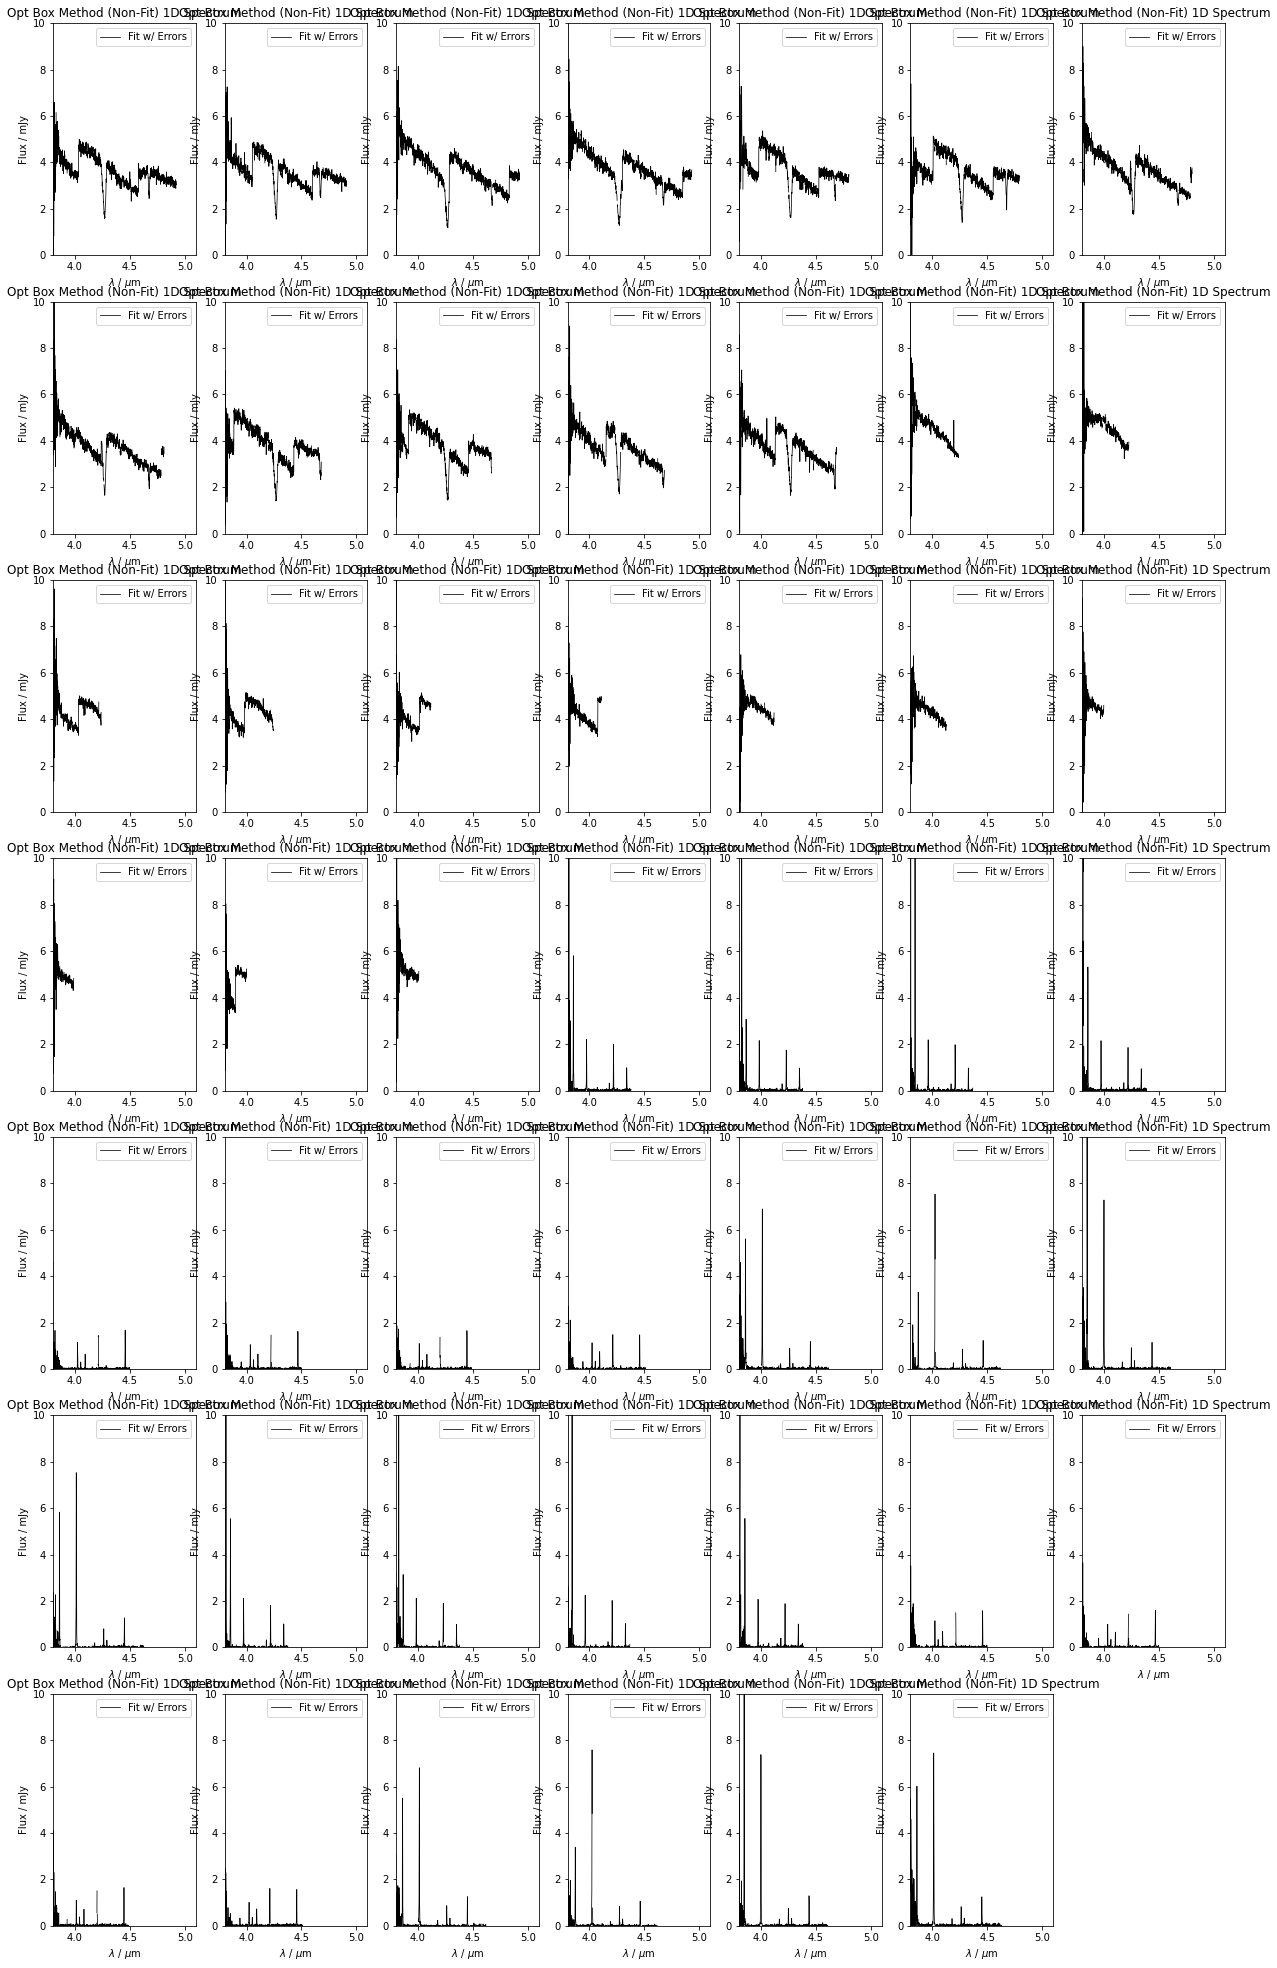

In [174]:
mplplot.figure(
    figsize=(
        np.round(np.sqrt(len(ChosenSourceStandIPFlux))).astype(int) * 3,
        np.round(np.sqrt(len(ChosenSourceStandIPFlux))).astype(int) * 5,
    )
)
mplplot.subplots_adjust(hspace=0.2)
# mplplot.suptitle("Daily closing prices", fontsize=18, y=0.95)

# set number of columns (use 3 to demonstrate the change)
ncols = np.round(np.sqrt(len(ChosenSourceStandIPFlux))).astype(int)
# calculate number of rows
nrows = np.round(np.sqrt(len(ChosenSourceStandIPFlux))).astype(int)

# loop through the length of tickers and keep track of index
for i in range(len(ChosenSourceWLs)):
    # add a new subplot iteratively using nrows and cols
    ax = mplplot.subplot(nrows, ncols, i + 1)

    # ax.errorbar(
    #     ChosenSourceWLs.iloc[i],
    #     ChosenSourceStandIPFlux.iloc[i],
    #     yerr=ChosenSourceStandIPErr.iloc[i],
    #     color="k",
    #     lw=0.75,
    #     ecolor="r",
    #     elinewidth=1,
    #     label="PSF Standard IP Fit w/ Errors",
    # )  # alpha=0.3,
    # ax.plot(
    #     ChosenSourceInputSpecWL.iloc[i],
    #     ChosenSourceInputSpecFlux.iloc[i] * 25,
    #     color="b",
    #     zorder=10,
    # )
    # ax.set_title("PSF (Standard IPs) Fitted 1D Spectrum")
    # ax.set_xlabel("$\lambda$ / $\mu$m")
    # ax.set_xlim(3.8, 5.1)
    # ax.set_ylim(-0.5, 10)
    # ax.set_ylabel("Flux / mJy")
    # ax.legend(loc="best")
    # # ax.tight_layout()

    ax.plot(
        ChosenSourceWLs.iloc[i],
        ChosenOptBox.iloc[i],
        # yerr=ChosenSourceErr.iloc[1],
        color="k",
        lw=0.75,
        # ecolor="r",
        # elinewidth=1,
        label="Fit w/ Errors",
    )  # alpha=0.3,

    ax1.plot(
        ChosenSourceInputSpecWL.iloc[i],
        ChosenSourceInputSpecFlux.iloc[i] * 25,
        color="b",
        zorder=10,
    )

    ax.set_title("Opt Box Method (Non-Fit) 1D Spectrum")
    ax.set_xlabel("$\lambda$ / $\mu$m")
    ax.set_xlim(3.8, 5.1)
    ax.set_ylim(0, 10)
    ax.set_ylabel("Flux / mJy")
    ax.legend(loc="best")
